In [1]:
from __future__ import print_function
from __future__ import division

In [2]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [3]:
from IPython.display import Image

In [4]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
from scipy.stats import binned_statistic, scoreatpercentile

In [6]:
## from params.py
# Directory containing the fits files.
source_dir = "../../fits/"

# Full sample of galaxies (to be voronoi binned). This should contain all of the galaxies in the sample.
full_sample = "full_sample.fits" 

# Volume-limited galaxy sample to be debiased.
vl_sample = "volume_limited_sample.fits" 

data_file = source_dir + full_sample

In [7]:
## from 01_select.py

def select_data_arm_number(data_file=data_file, N_cut=5, p_cut=0.5):
    data = fits.getdata(data_file, 1)

    p_spiral=(data.field("t01_smooth_or_features_a02_features_or_disk_debiased") *
              data.field("t02_edgeon_a05_no_debiased") *
              data.field("t04_spiral_a08_spiral_debiased"))

    N_spiral=(data.field("t04_spiral_a08_spiral_count"))

    # Only include galaxies with >= N_cut spiral votes.
    # Only include galaxies with > p_cut spiral vote fraction.
    select = (p_spiral > p_cut) & (N_spiral >= N_cut)
    data = data[select]

    data = Table(data)
    return data

In [8]:
arm_question='t11_arms_number'
arm_answers=('a31_1', 'a32_2', 'a33_3', 'a34_4',
             'a36_more_than_4', 'a37_cant_tell')
arm_answerlabels = ('1 arm', '2 arms', '3 arms',
                    '4 arms', '5+ arms', '?? arms')

In [9]:
data = select_data_arm_number()
R50, Mr = [data[c] for c in ["PETROR50_R_KPC","PETROMAG_MR"]]
# binning performed in log10(R50)
R50 = np.log10(R50)

In [10]:
## from 10_voronoi_binning.py

from voronoi_2d_binning import voronoi_2d_binning

def voronoi_binning(R50, Mr, n_rect_bins=500, n_per_voronoi_bin=625):
    rect_bin_val, R50_bin_edges, Mr_bin_edges = np.histogram2d(R50, Mr, n_rect_bins)

    rect_bins_table = Table(data=[R50_bin_edges, Mr_bin_edges],
                            names=['R50_bin_edges', 'Mr_bin_edges'])
    rect_bins_table.meta['nrectbin'] = n_rect_bins
    rect_bins_table.write(source_dir + 'rect_bins_table.fits', overwrite=True)
    
    R50_bin_centres = 0.5*(R50_bin_edges[:-1] + R50_bin_edges[1:])
    Mr_bin_centres = 0.5*(Mr_bin_edges[:-1] + Mr_bin_edges[1:])
    n_R50_bins = len(R50_bin_centres)
    n_Mr_bins = len(Mr_bin_centres)

    R50_bins_min, Mr_bins_min = map(np.min, (R50_bin_centres, Mr_bin_centres))
    R50_bins_max, Mr_bins_max = map(np.max, (R50_bin_centres, Mr_bin_centres))
    R50_bins_range = R50_bins_max - R50_bins_min
    Mr_bins_range = Mr_bins_max - Mr_bins_min

    R50_bin_coords = R50_bin_centres.repeat(n_rect_bins).reshape(n_rect_bins, n_rect_bins).ravel()
    Mr_bin_coords = Mr_bin_centres.repeat(n_rect_bins).reshape(n_rect_bins, n_rect_bins).T.ravel()

    # only keep bins that contain a galaxy
    signal = rect_bin_val.ravel()
    ok_bin = (signal > 0).nonzero()[0]
    signal = signal[ok_bin]

    # create normalised variables for non-zero bins
    x = (R50_bin_coords[ok_bin] - R50_bins_min) / R50_bins_range
    y = (Mr_bin_coords[ok_bin] - Mr_bins_min) / Mr_bins_range

    # voronoi_2d_binning aims for a target S/N
    noise = np.sqrt(signal)
    targetSN = np.sqrt(n_per_voronoi_bin)

    output = voronoi_2d_binning(x, y, signal, noise, targetSN, plot=0, quiet=1, wvt=True)
    binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = output

    vbin = np.unique(binNum)
    count = (sn**2).astype(np.int)
    R50_vbin_mean = xBar * R50_bins_range + R50_bins_min
    Mr_vbin_mean = yBar * Mr_bins_range + Mr_bins_min
    
    vbins_table = Table(data=[vbin, R50_vbin_mean, Mr_vbin_mean,
                              count, nPixels],
                        names=['vbin', 'R50', 'Mr', 
                               'count_gals', 'count_rect_bins'])
    vbins_table.meta['nrectbin'] = n_rect_bins
    vbins_table.meta['nperbin'] = n_per_voronoi_bin
    vbins_table.write(source_dir + 'vbins_table.fits', overwrite=True)

    # populate elements of the rectangular grid with
    # the voronoi bin indices and counts
    rect_bin_voronoi_bin = np.zeros(np.product(rect_bin_val.shape), np.int) - 1
    rect_bin_voronoi_bin[ok_bin] = binNum
    rect_bin_count = np.zeros_like(rect_bin_voronoi_bin)
    rect_bin_count[ok_bin] = count
    
    rect_vbins_table = Table(data=[R50_bin_coords, Mr_bin_coords,
                             rect_bin_voronoi_bin],
                             names=['R50', 'Mr', 'vbin'])
    rect_bins_table.meta['nrectbin'] = n_rect_bins
    rect_bins_table.meta['nperbin'] = n_per_voronoi_bin
    rect_vbins_table.write(source_dir + 'rect_vbins_table.fits', overwrite=True)
    
    return rect_bins_table, vbins_table, rect_vbins_table

In [11]:
## from 11_voronoi_assignment.py

def voronoi_assignment(R50, Mr, rect_bins_table, rect_vbins_table):
    R50_bin_edges = rect_bins_table['R50_bin_edges']
    Mr_bin_edges = rect_bins_table['Mr_bin_edges']
    n_R50_bins = len(R50_bin_edges) - 1
    n_Mr_bins = len(Mr_bin_edges) - 1
    
    # get the R50 and Mr bin for each galaxy in the sample
    R50_bins = np.digitize(R50, bins=R50_bin_edges).clip(1, n_R50_bins)
    Mr_bins = np.digitize(Mr, bins=Mr_bin_edges).clip(1, n_Mr_bins)

    # convert R50 and Mr bin indices to indices of bins
    # in the combined rectangular grid
    rect_bins = (Mr_bins - 1) + n_Mr_bins * (R50_bins - 1)

    # get the voronoi bin for each galaxy in the sample
    rect_bin_vbins = rect_vbins_table['vbin']
    voronoi_bins = rect_bin_vbins[rect_bins]
    
    return voronoi_bins

In [12]:
rect_bins_table, vbins_table, rect_vbins_table = voronoi_binning(R50, Mr)

Bin-accretion...
914  initial bins.
Reassign bad bins...
30  good bins.
Modified Lloyd algorithm...
28  iterations.
Unbinned pixels:  0  /  19352
Fractional S/N scatter (%): 28.6055763792


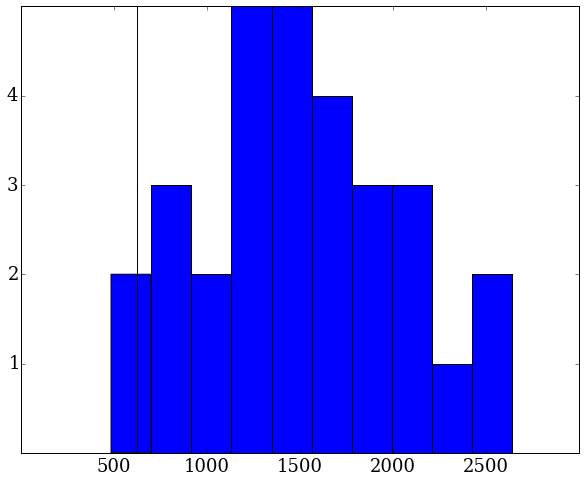

In [13]:
count = vbins_table['count_gals']
count = count[count > 0]
plt.hist(count)
_ = plt.vlines([vbins_table.meta['nperbin']], *plt.axis()[2:])

In [14]:
voronoi_bins = voronoi_assignment(R50, Mr, rect_bins_table, rect_vbins_table)

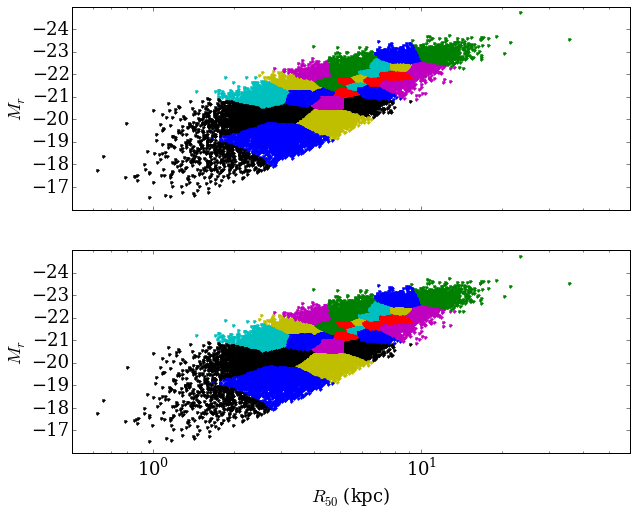

In [15]:
## from 11_voronoi_assignment.py

vbin = rect_vbins_table['vbin']
R50_bin_coords = rect_vbins_table['R50']
Mr_bin_coords = rect_vbins_table['Mr']

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

for N in np.unique(vbin[vbin >= 0]):
    inbin = vbin == N
    ax1.plot(10**R50_bin_coords[inbin], Mr_bin_coords[inbin], '.')
ax1.set_ylabel(r"$M_r$")
ax1.set_xscale('log')
    
for N in np.unique(voronoi_bins):
    inbin = voronoi_bins == N
    ax2.plot(10**R50[inbin], Mr[inbin], '.')
ax2.set_ylabel(r"$M_r$")
ax2.set_xlabel(r"$R_{50}$ (kpc)")
ax2.set_xscale('log')
_ = ax2.axis((0.5, 60, -16, -25))

In [16]:
## from 11_voronoi_assignment.py

def redshift_binning(data, voronoi_bins,
                     question='t11_arms_number',
                     answers=('a31_1', 'a32_2', 'a33_3', 'a34_4',
                              'a36_more_than_4', 'a37_cant_tell'),
                     min_gals=50):
    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]
    redshift = data['REDSHIFT_1']
    z_bins = np.zeros((len(morph_fv_cols), len(data)), np.int)

    for N in np.unique(voronoi_bins):
        inbin = voronoi_bins == N
        for m, fv_col in enumerate(morph_fv_cols):
            # Select bins such that >= min_gals objects
            # with at least one vote are in each bin
            has_morph = data[fv_col][inbin] > 0
            n_with_morph = (has_morph).sum()
            n_zbins = n_with_morph / min_gals 
            n_zbins = max(n_zbins, 5)
            z = redshift[inbin]
            z_with_morph = z[has_morph]
            z_with_morph.sort()
            bin_edges = np.linspace(0, len(z_with_morph)-1, n_zbins+1, dtype=np.int)
            z_edges = z_with_morph[bin_edges]
            z_edges[0] = 0
            z_edges[-1] = 1
            z_bins[m, inbin] = np.digitize(z, z_edges)

    return z_bins

In [17]:
def save_bin_assignments(v_bins, z_bins, question='t11_arms_number'):
    assignments = Table(data=[v_bins], names=['vbin'])
    for m in range(len(z_bins)):
        zcol = 'zbin_{}'.format(m)
        assignments[zcol] = z_bins[m]
    assignments.write(source_dir + 'bin_assignments_{}.fits'.format(question),
                      overwrite=True)
    return assignments

In [18]:
redshift_bins = redshift_binning(data, voronoi_bins,
                                 question=arm_question,
                                 answers=arm_answers)
bin_assignments = save_bin_assignments(voronoi_bins,
                                       redshift_bins,
                                       question=arm_question)

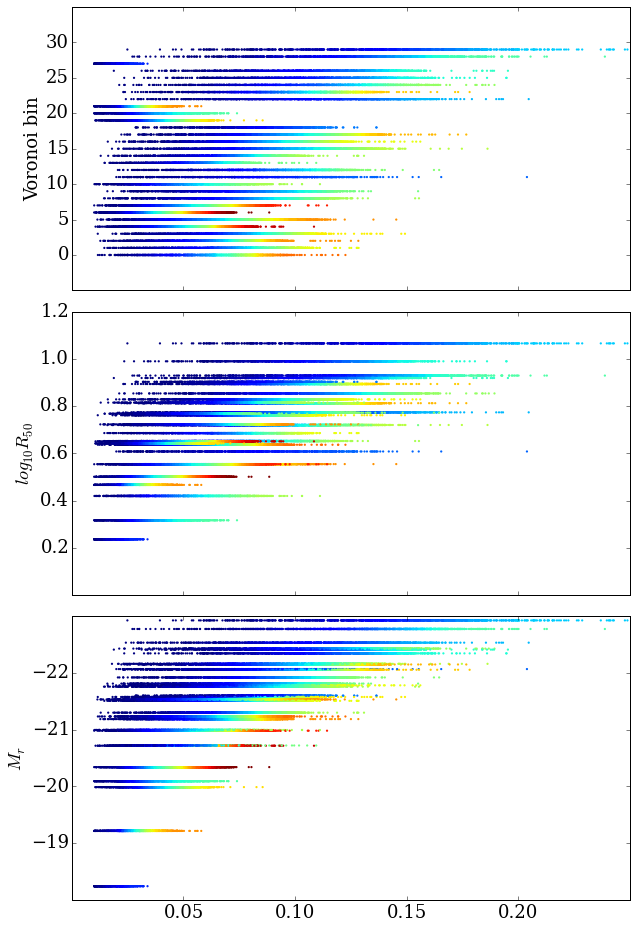

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10,16))

ax1.scatter(data['REDSHIFT_1'], voronoi_bins, c=redshift_bins[1], marker='.', edgecolor='none')
ax1.set_ylabel("Voronoi bin")
ax2.scatter(data['REDSHIFT_1'], vbins_table['R50'][voronoi_bins], c=redshift_bins[1], marker='.', edgecolor='none')
ax2.set_ylabel("$log_{10}{R_{50}}$")
sc = ax3.scatter(data['REDSHIFT_1'], vbins_table['Mr'][voronoi_bins], c=redshift_bins[1], marker='.', edgecolor='none')
ax3.set_ylabel("$M_r$")
_ = ax3.axis((0.0, 0.25, -18, -23))
fig.subplots_adjust(hspace=0.075)

In [20]:
def f_logistic(x, k, c):
    # Function to fit the data bin output from the raw plot function
    L = 1 + np.exp(c)
    r = L / (1.0 + np.exp(-k * x + c))
    return r


def f_exp(x, k):
    # Function to fit the data bin output from the raw plot function
    r = np.exp(k * x)
    return r


def f_exp_pow(x, k, c):
    # Function to fit the data bin output from the raw plot function
    r = np.exp(-k * (-x) ** c)
    return r


def chisq_fun(p, f, x, y):
    return ((f(x, *p) - y)**2).sum()

In [21]:
def i_f_logistic(y, k, c):
    # inverse of f_logistic
    L = 1 + np.exp(c)
    x = -(np.log(L / y - 1) - c) / k
    return x

def i_f_exp_pow(y, k, c):
    # inverse of f_exp_pow
    ok = k > 0
    x = np.zeros_like(y) - np.inf
    x[ok] = -(-np.log(y[ok]) /k[ok] )**(1.0/c[ok])
    return x

def inverse_f(f):
    if f == f_logistic:
        return i_f_logistic
    elif f == f_exp_pow:
        return i_f_exp_pow

In [22]:
def plot_raw(ax, D, color):
    # Plot cumulative fractions for the raw data
    ax.plot(D['log10fv'], D['cumfrac'], '-', color=color, lw=2, alpha=0.2)


def plot_function(ax, f, x, p, color, style='--'):
    # Plot fitted function to cumulative fractions
    ax.plot(x, f(x, *p), style, color=color, lw=0.5)


def plot_guides(ax):
    # Plot guides at 20%, 50%, 80%
    x_guides = np.log10([0.2, 0.5, 0.8])
    y_guides = np.array([0, 1.05])
    for xg in x_guides:
        ax.plot([xg, xg], y_guides, color=[0, 0, 0], alpha=0.3)

        
def plot_limits(x, p=1, d=0.05):
    low, high = scoreatpercentile(x, (p, 100-p))
    diff = high-low
    low -= d * diff
    high += d * diff
    return low, high


def finish_vbin_plot(fig, ax, answerlabels, m, v):
    plot_guides(ax)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xticks(np.arange(-1.5, 0.1, 0.5))
    ax.text(-1.9, 0.95, answerlabels[m],
            fontsize=10, ha='left')
    ax.set_ylim([0, 1.05])
    if m > 2:
        ax.set_xlabel(r'$\log(v_f)$')
    if m in (0, 3):
        ax.set_ylabel('Cumulative fraction')
    if m == 1:
        ax.set_title('Voronoi bin %02i' % v)
    fig.subplots_adjust(wspace=0, hspace=0)

In [23]:
from scipy.optimize import minimize

def fit_vbin_function(data, bin_assignments, fit_setup,
                      question='t11_arms_number',
                      answers=('a31_1', 'a32_2', 'a33_3', 'a34_4',
                               'a36_more_than_4', 'a37_cant_tell'),
                      answerlabels=('1 arm', '2 arms', '3 arms',
                                    '4 arms', '5+ arms', '?? arms'),
                      min_fv=0.01,
                      kc_fit_results=None,
                      plot=True):
    # Output fitted function for each of the Voronoi bins,
    # arm numbers and redshift bins.

    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]
    redshift = data['REDSHIFT_1']
    vbins = bin_assignments['vbin']

    if kc_fit_results is not None:
        kcfunc, kparams, cparams, kclabel = kc_fit_results
    
    # Set up the list to write the parameters in to:
    param_data = []
    
    max_z_bins_to_plot = 5
    
    # Loop over Voronoi magnitude-size bins
    for v in np.unique(vbins):
        vselect = vbins == v
        data_v = data[vselect]
        bin_assignments_v = bin_assignments[vselect]

        if plot:
            fig, axarr = plt.subplots(2, 3, sharex='col', sharey='row')
            axarr = axarr.ravel()
            x = np.linspace(-2, 0, 1000)

        # Loop over morphological categories
        for m, fv in enumerate(morph_fv_cols):
            z_bins = bin_assignments_v['zbin_{}'.format(m)]
            z_bins_unique = np.unique(z_bins)
            n_z_bins = len(z_bins_unique)
            z_bins_to_plot = z_bins_unique[::(n_z_bins // max_z_bins_to_plot) + 1]
            z_min = z_bins.min()
            z_max = z_bins.max()
            clr_diff = (1.0 / (z_max - z_min)) if z_max - z_min != 0 else 0

            # Loop over redshift slices
            for z in z_bins_unique:
                data_z = data_v[z_bins == z]
                n = len(data_z)
                clr_z = [min((z - 1) * clr_diff, 1), 0,
                         max(1 - (z - 1) * clr_diff, 0)]

                # Compute cumulative fraction
                D = data_z[[fv]]
                D.sort(fv)
                D['cumfrac'] = np.linspace(0, 1, n)
                D = D[D[fv] > min_fv]
                D['log10fv'] = np.log10(D[fv])

                # Fit function to the cumulative fraction
                # Start fits off in roughly right place with sensible bounds
                func, p0, bounds = get_fit_setup(fit_setup, m)
                # Note that need to cast x and y to float64 in order
                # for minimisation to work correctly
                res = minimize(chisq_fun, p0,
                               args=(func,
                                     D['log10fv'].astype(np.float64),
                                     D['cumfrac'].astype(np.float64)),
                               bounds=bounds, method='SLSQP')
                p = res.x
                chi2nu = res.fun / (n - len(p))
                
                means = [data_z['PETROMAG_MR'].mean(),
                         np.log10(data_z['PETROR50_R_KPC']).mean(),
                         data_z['REDSHIFT_1'].mean()]
                                
                if plot and z in z_bins_to_plot:
                    ax = axarr[m]
                    plot_raw(ax, D, clr_z)
                    plot_function(ax, func, x, p, clr_z)
                    if kc_fit_results is not None:
                        kf = kcfunc(means, *kparams[m])
                        cf = kcfunc(means, *cparams[m])
                        plot_function(ax, func, x, (kf, cf), clr_z, style=':')

                if len(p) < 2:
                    p = np.array([p[0], 10])

                param_data.append([v, m, z] + means + p[:2].tolist() +
                                  [chi2nu])

            if plot:
                finish_vbin_plot(fig, ax, answerlabels, m, v)
        if plot:
            suffix = '_kcfit{}'.format(kclabel) if kc_fit_results is not None else ''
            fig.savefig('plots/fit_{}_vbin{:02d}{}.pdf'.format(question, v, suffix),
                        dpi=100)
            plt.close()

    fit_vbin_results = Table(rows=param_data,
                             names=('vbin', 'answer', 'zbin', 'Mr',
                                    'R50', 'redshift', 'k', 'c', 'chi2nu'))
    fit_vbin_results.write(source_dir + 'fit_vbin_results_{}.fits'.format(question),
                           overwrite=True)
    return fit_vbin_results

In [24]:
def get_fit_setup(fit_setup, m):
    def get_m(x):
        return x[m] if m in x.keys() else x[None]
    func = get_m(fit_setup['func'])
    p0 = get_m(fit_setup['p0'])
    bounds = get_m(fit_setup['bounds'])
    return func, p0, bounds

In [25]:
# fit setup for arm number
fit_setup = {}
fit_setup['func'] = {None: f_logistic,
                     1: f_exp_pow}
fit_setup['p0'] = {None: [3, -3],
                   1: [3, 1]}
fit_setup['bounds'] = {None: ((0.5, 6), (-7.5, 0)),
                       1: ((0.5, 10), (0.01, 3))}

In [26]:
fit_vbin_results = fit_vbin_function(data, bin_assignments, fit_setup,
                                     question=arm_question,
                                     answers=arm_answers,
                                     answerlabels=arm_answerlabels,
                                     plot=False)

In [27]:
#Image('plots/fit_t11_arms_number_vbin13.png')

In [28]:
def plot_fit_vbin(parameter='k', predictor=None,
                 answerlabels=arm_answerlabels):
    fig, axarr = plt.subplots(6, 3, sharey='row', sharex='col', figsize=(16,16))
    def plot(ax, x, answer, colourby):
        r = fit_vbin_results[fit_vbin_results['answer'] == answer]
        if predictor is None:
            param = r[parameter]
        else:
            f, p = predictor
            var = np.array([r[c] for c in ['Mr', 'R50', 'redshift']], np.float64)
            if p is not None:
                param = f(var, *p[answer])
            else:
                param = f(var)
        ax.scatter(r[x], param, c=r[colourby], marker='.', edgecolor='')
        y, bin_edges, binnumber = binned_statistic(r[x], r[parameter], statistic='median')
        xc = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax.plot(xc, y, 'k-')
        if predictor is not None:
            y, bin_edges, binnumber = binned_statistic(r[x], param, statistic='median')
            xc = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            ax.plot(xc, y, 'k--')
        low, high = plot_limits(r[parameter])
        ax.axis(ymin=low, ymax=high)
    for a, axrow in enumerate(axarr):
        plot(axrow[0], 'redshift', a, 'vbin')
        plot(axrow[1], 'R50', a, 'redshift')
        plot(axrow[2], 'Mr', a, 'redshift')
        axrow[0].set_ylabel("${}$ ({})".format(parameter, answerlabels[a]))
        if a == len(axarr) - 1:
            axrow[0].set_xlabel('$z$')
            axrow[1].set_xlabel('$\log_{10}{R_{50}}$')
            axrow[2].set_xlabel('$M_r$')
    fig.subplots_adjust(hspace=0, wspace=0)

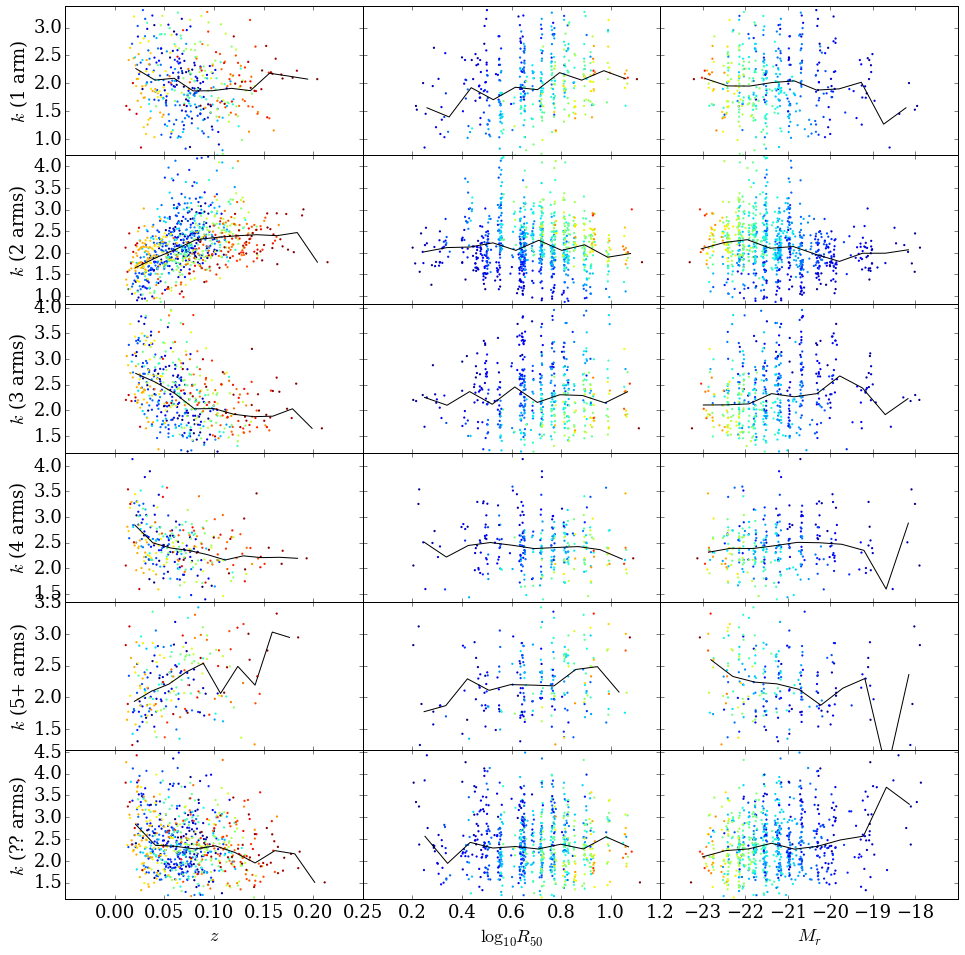

In [29]:
plot_fit_vbin('k', answerlabels=arm_answerlabels)
plt.savefig('plots/k_x.pdf')

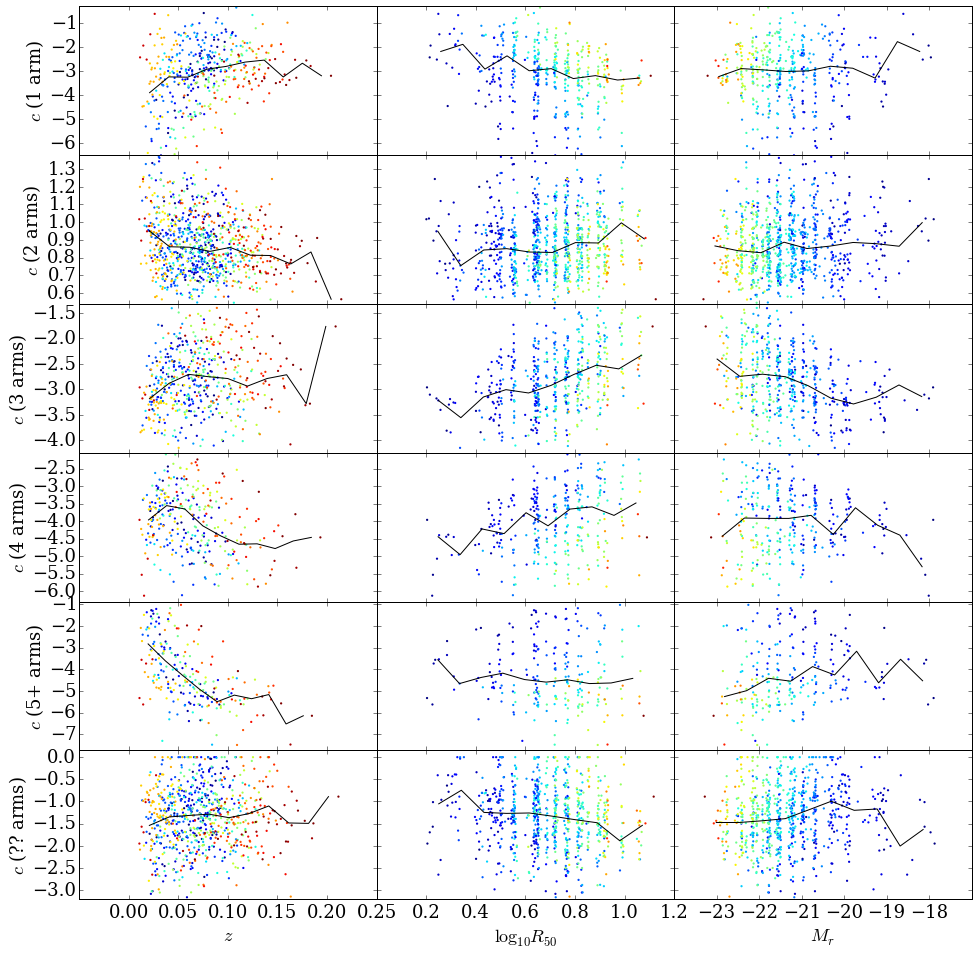

In [30]:
plot_fit_vbin('c', answerlabels=arm_answerlabels)
plt.savefig('plots/c_x.pdf')

In [31]:
from scipy.optimize import curve_fit

def kcfunc(x, A0, AM, AR, Az):
    # linear combination of (magnitude, size, redshift) + an offset
    r = A0 + AM*x[0] + AR*x[1] + Az*x[2]    
    return r


def kcfunc2(x,A0,AM,AR,Az,BM,BR,Bz):
    # linear combination of (magnitude, size, redshift) + their squares + an offset
    r = A0 + AM*x[0] + AR*x[1] + Az*x[2] + BM*x[0]**2 + BR*x[1]**2 + Bz*x[2]**2    
    return r


def fit_mrz(d, f=kcfunc2):
    # Fit a linear function of M, R and z to k and c

    answers = d['answer']
    answer_list = np.unique(answers)
    n_answers = len(answer_list)
    
    dout = d.copy()
    dout['kf'] = np.zeros(len(d))
    dout['cf'] = np.zeros(len(d))
    
    kparams = []
    cparams = []
    
    kmin = [d[answers == a]['k'].min() for a in answer_list]
    kmax = [d[answers == a]['k'].max() for a in answer_list] 
    cmin = [d[answers == a]['c'].min() for a in answer_list]
    cmax = [d[answers == a]['c'].max() for a in answer_list] 

    # Loop over GZ morphologies
    for a in answer_list:
        select = answers == a
        da = d[select]
        x = np.array([da[c] for c in ['Mr', 'R50', 'redshift']], np.float64)
        k = da['k'].astype(np.float64)
        c = da['c'].astype(np.float64)

        kp, kc = curve_fit(f, x, k, maxfev=1000)
        cp, cc = curve_fit(f, x, c, maxfev=1000)
        
        dout['kf'][select] = f(x, *kp)
        dout['cf'][select] = f(x, *cp)

        kparams.append(kp)
        cparams.append(cp)

    return kparams, cparams, dout, kmin, kmax, cmin, cmax

In [32]:
kparams, cparams, dout, kmin, kmax, cmin, cmax = fit_mrz(fit_vbin_results, kcfunc)

In [33]:
kparams2, cparams2, dout2, kmin, kmax, cmin, cmax = fit_mrz(fit_vbin_results, kcfunc2)

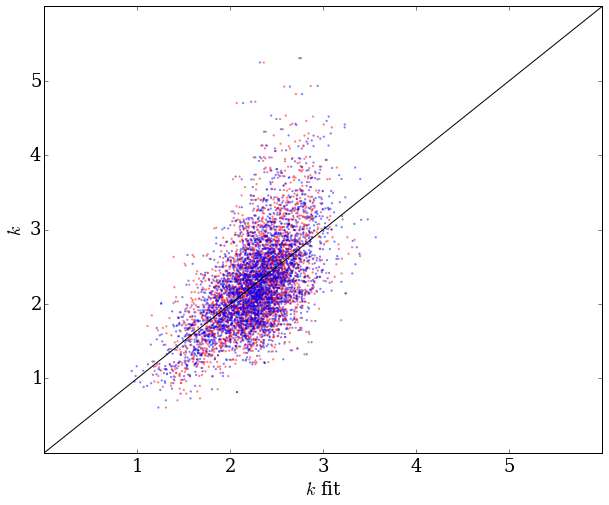

In [34]:
plt.scatter(dout['kf'], dout['k'], c='r',
            marker='.', edgecolor='', alpha=0.5)
plt.scatter(dout2['kf'], dout['k'], c='b',
            marker='.', edgecolor='', alpha=0.5)
plt.plot([0, 6], [0, 6], 'k-')
plt.xlabel('$k$ fit')
plt.ylabel('$k$')
_ = plt.axis((0, 6, 0, 6))

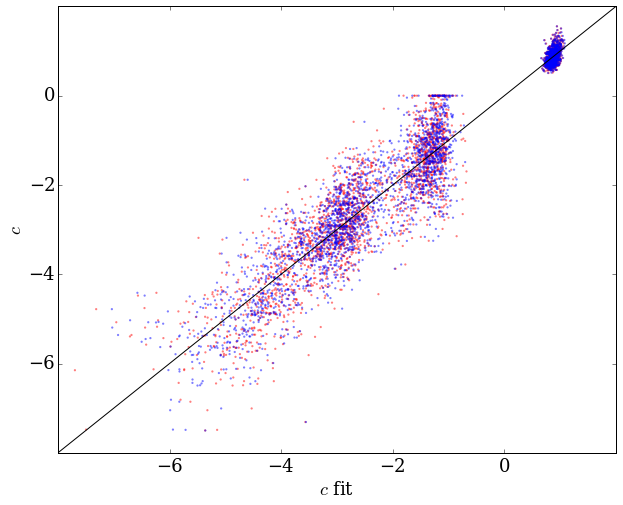

In [35]:
plt.scatter(dout['cf'], dout['c'], c='r',
            marker='.', edgecolor='', alpha=0.5)
plt.scatter(dout2['cf'], dout['c'], c='b',
            marker='.', edgecolor='', alpha=0.5)
plt.plot([-8, 2], [-8, 2], 'k-')
plt.xlabel('$c$ fit')
plt.ylabel('$c$')
_ = plt.axis((-8, 2, -8, 2))

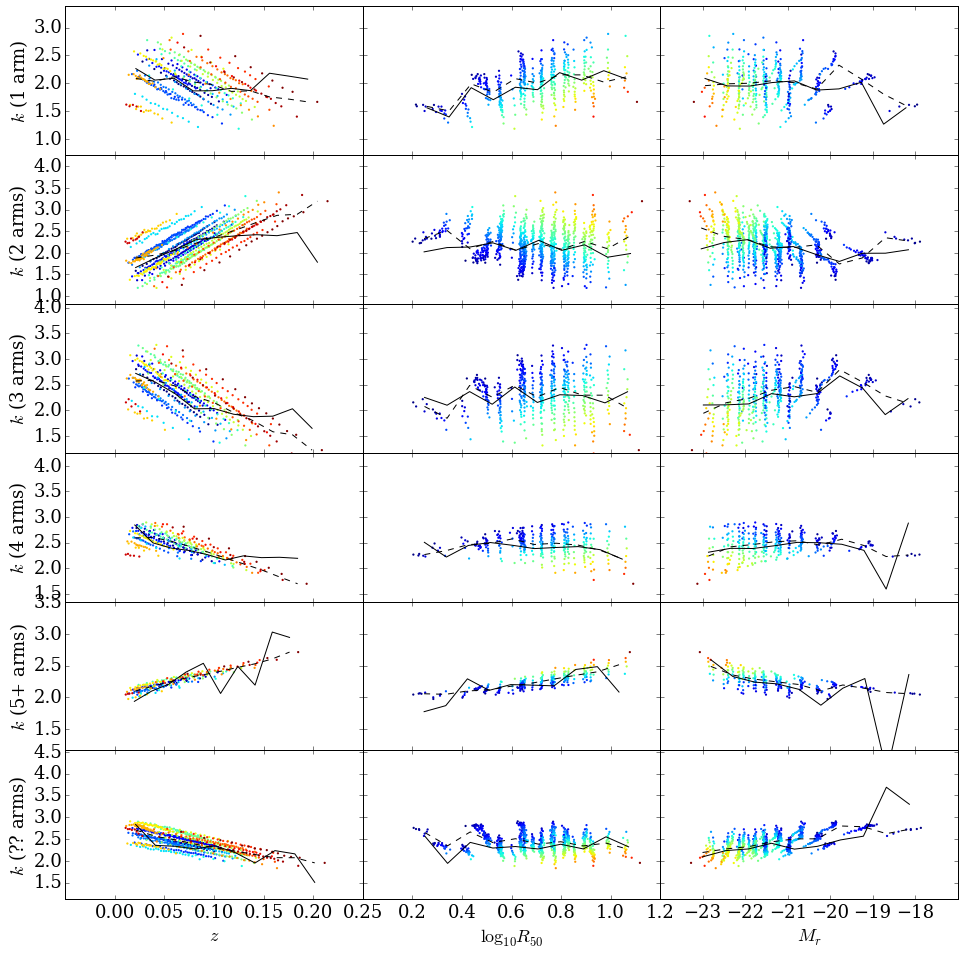

In [36]:
plot_fit_vbin('k', predictor=(kcfunc, kparams),
              answerlabels=arm_answerlabels)
plt.savefig('plots/k_x_fit1.pdf')

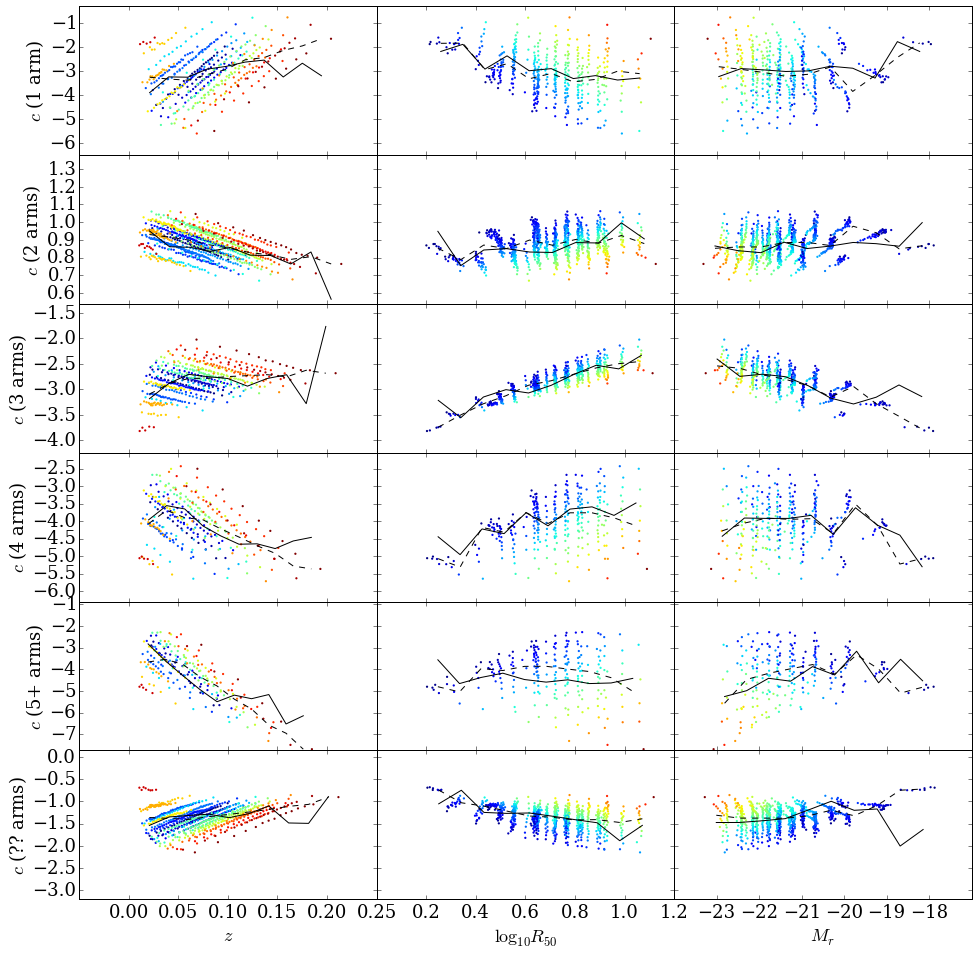

In [37]:
plot_fit_vbin('c', predictor=(kcfunc, cparams),
              answerlabels=arm_answerlabels)
plt.savefig('plots/c_x_fit1.pdf')

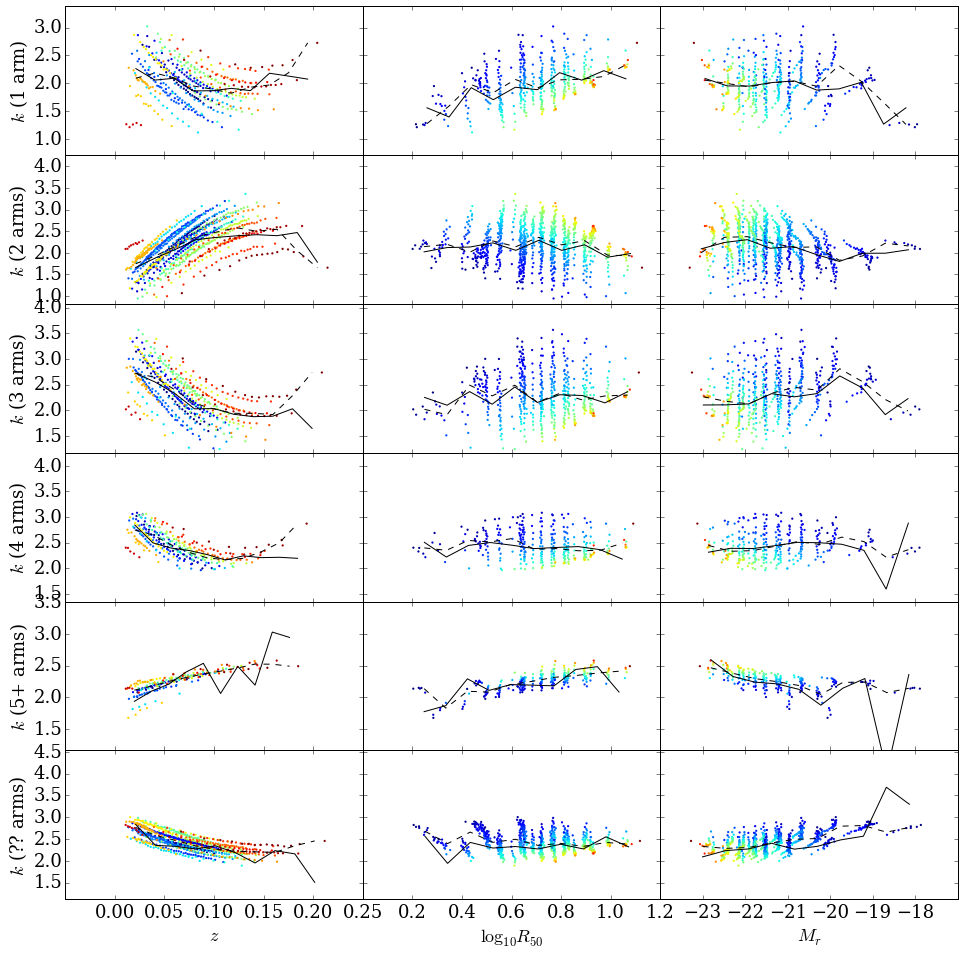

In [38]:
plot_fit_vbin('k', predictor=(kcfunc2, kparams2),
              answerlabels=arm_answerlabels)
plt.savefig('plots/k_x_fit2.pdf')

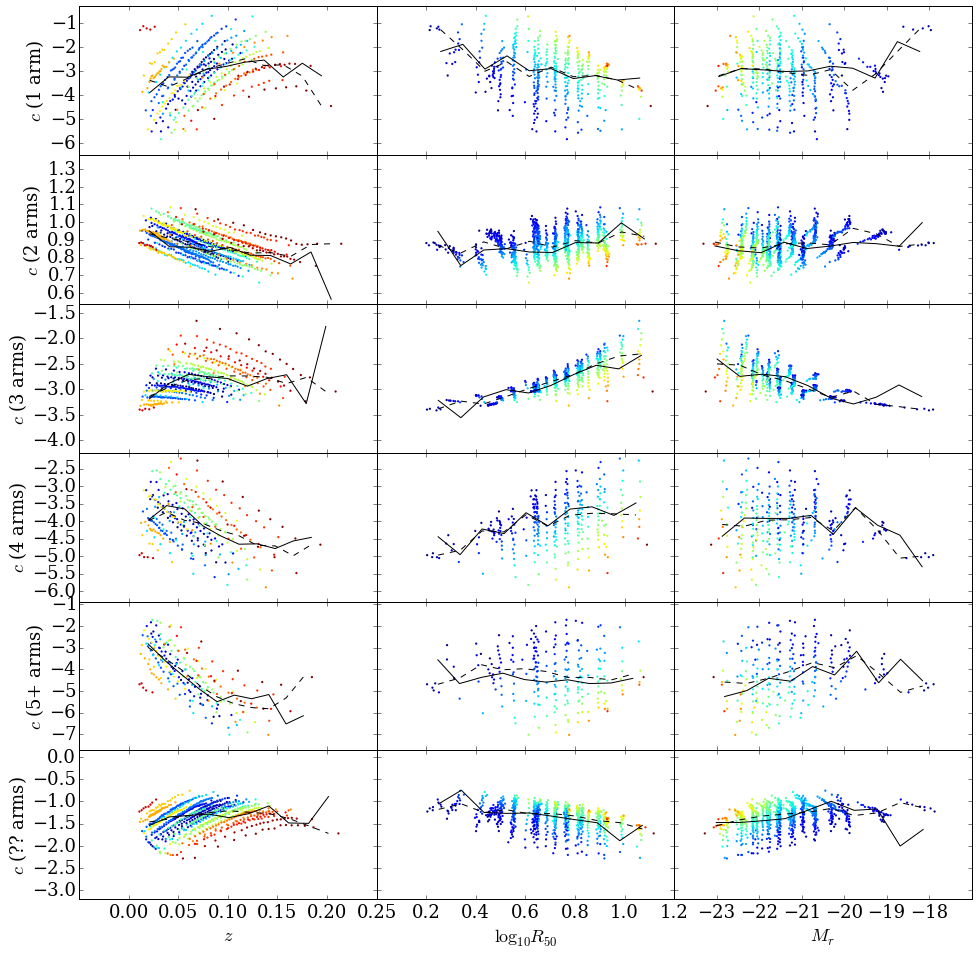

In [39]:
plot_fit_vbin('c', predictor=(kcfunc2, cparams2),
              answerlabels=arm_answerlabels)
plt.savefig('plots/c_x_fit2.pdf')

In [40]:
# plot cumulative histograms with adopted fit
fit_vbin_results = fit_vbin_function(data, bin_assignments, fit_setup,
                                     question=arm_question,
                                     answers=arm_answers,
                                     answerlabels=arm_answerlabels,
                                     kc_fit_results=(kcfunc, kparams, cparams, 1),
                                     plot=True)

In [41]:
# plot cumulative histograms with adopted fit
fit_vbin_results = fit_vbin_function(data, bin_assignments, fit_setup,
                                     question=arm_question,
                                     answers=arm_answers,
                                     answerlabels=arm_answerlabels,
                                     kc_fit_results=(kcfunc2, kparams2, cparams2, 2),
                                     plot=True)

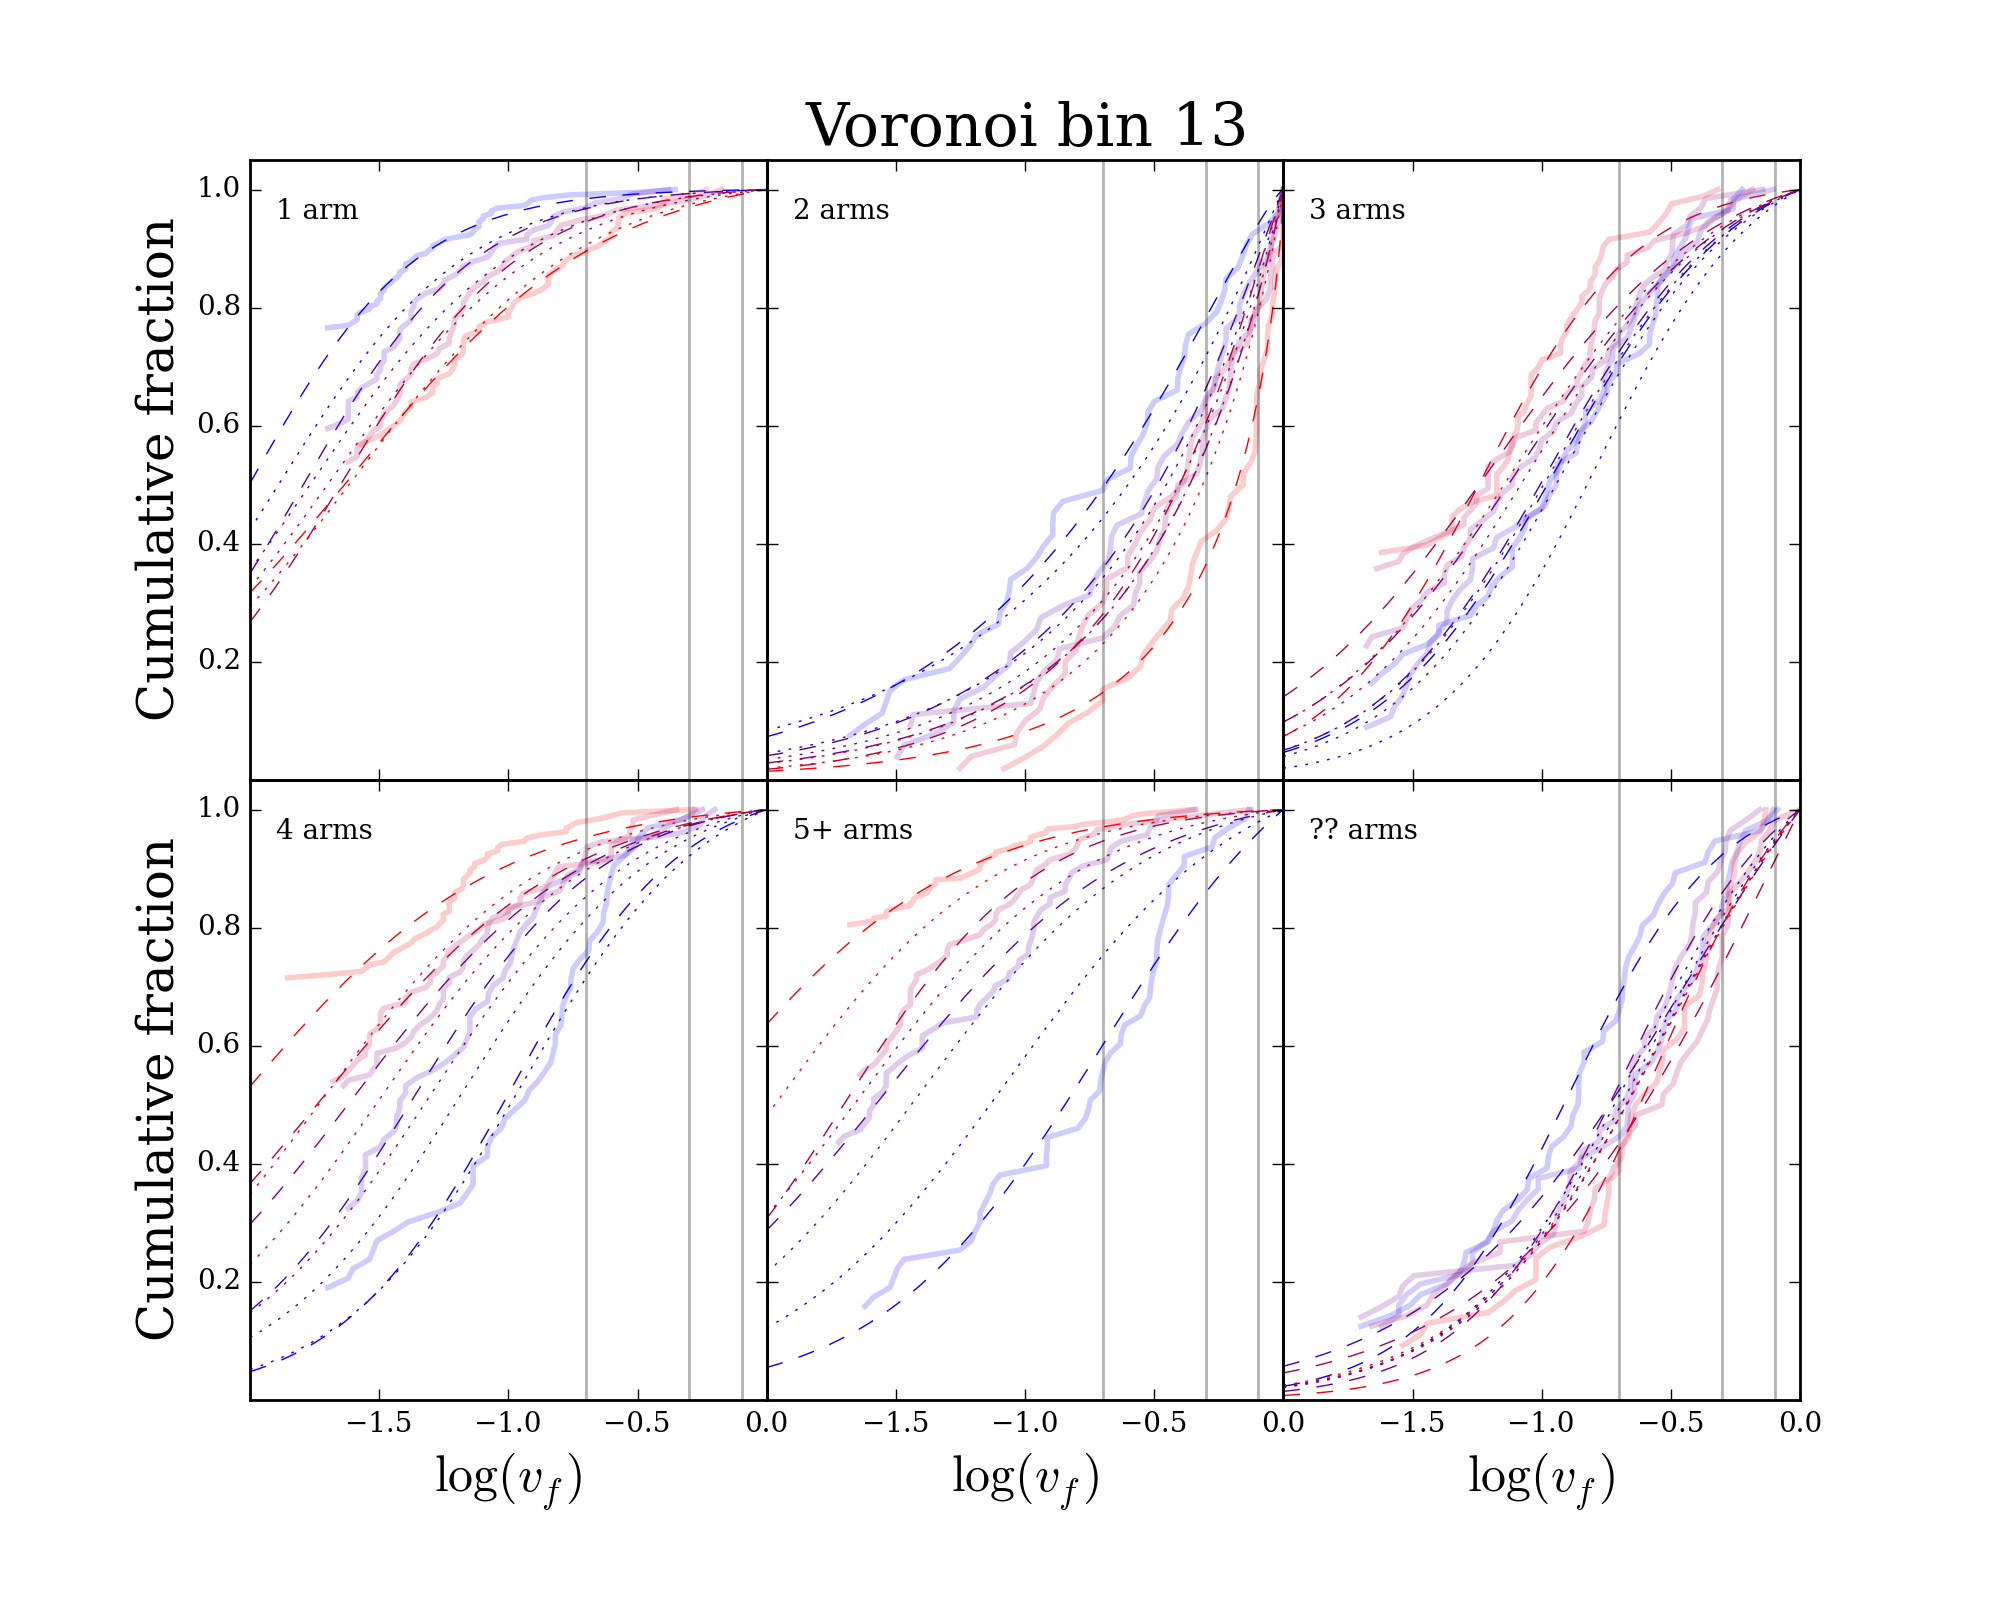

In [42]:
Image('plots/fit_t11_arms_number_vbin13_kcfit1.png')

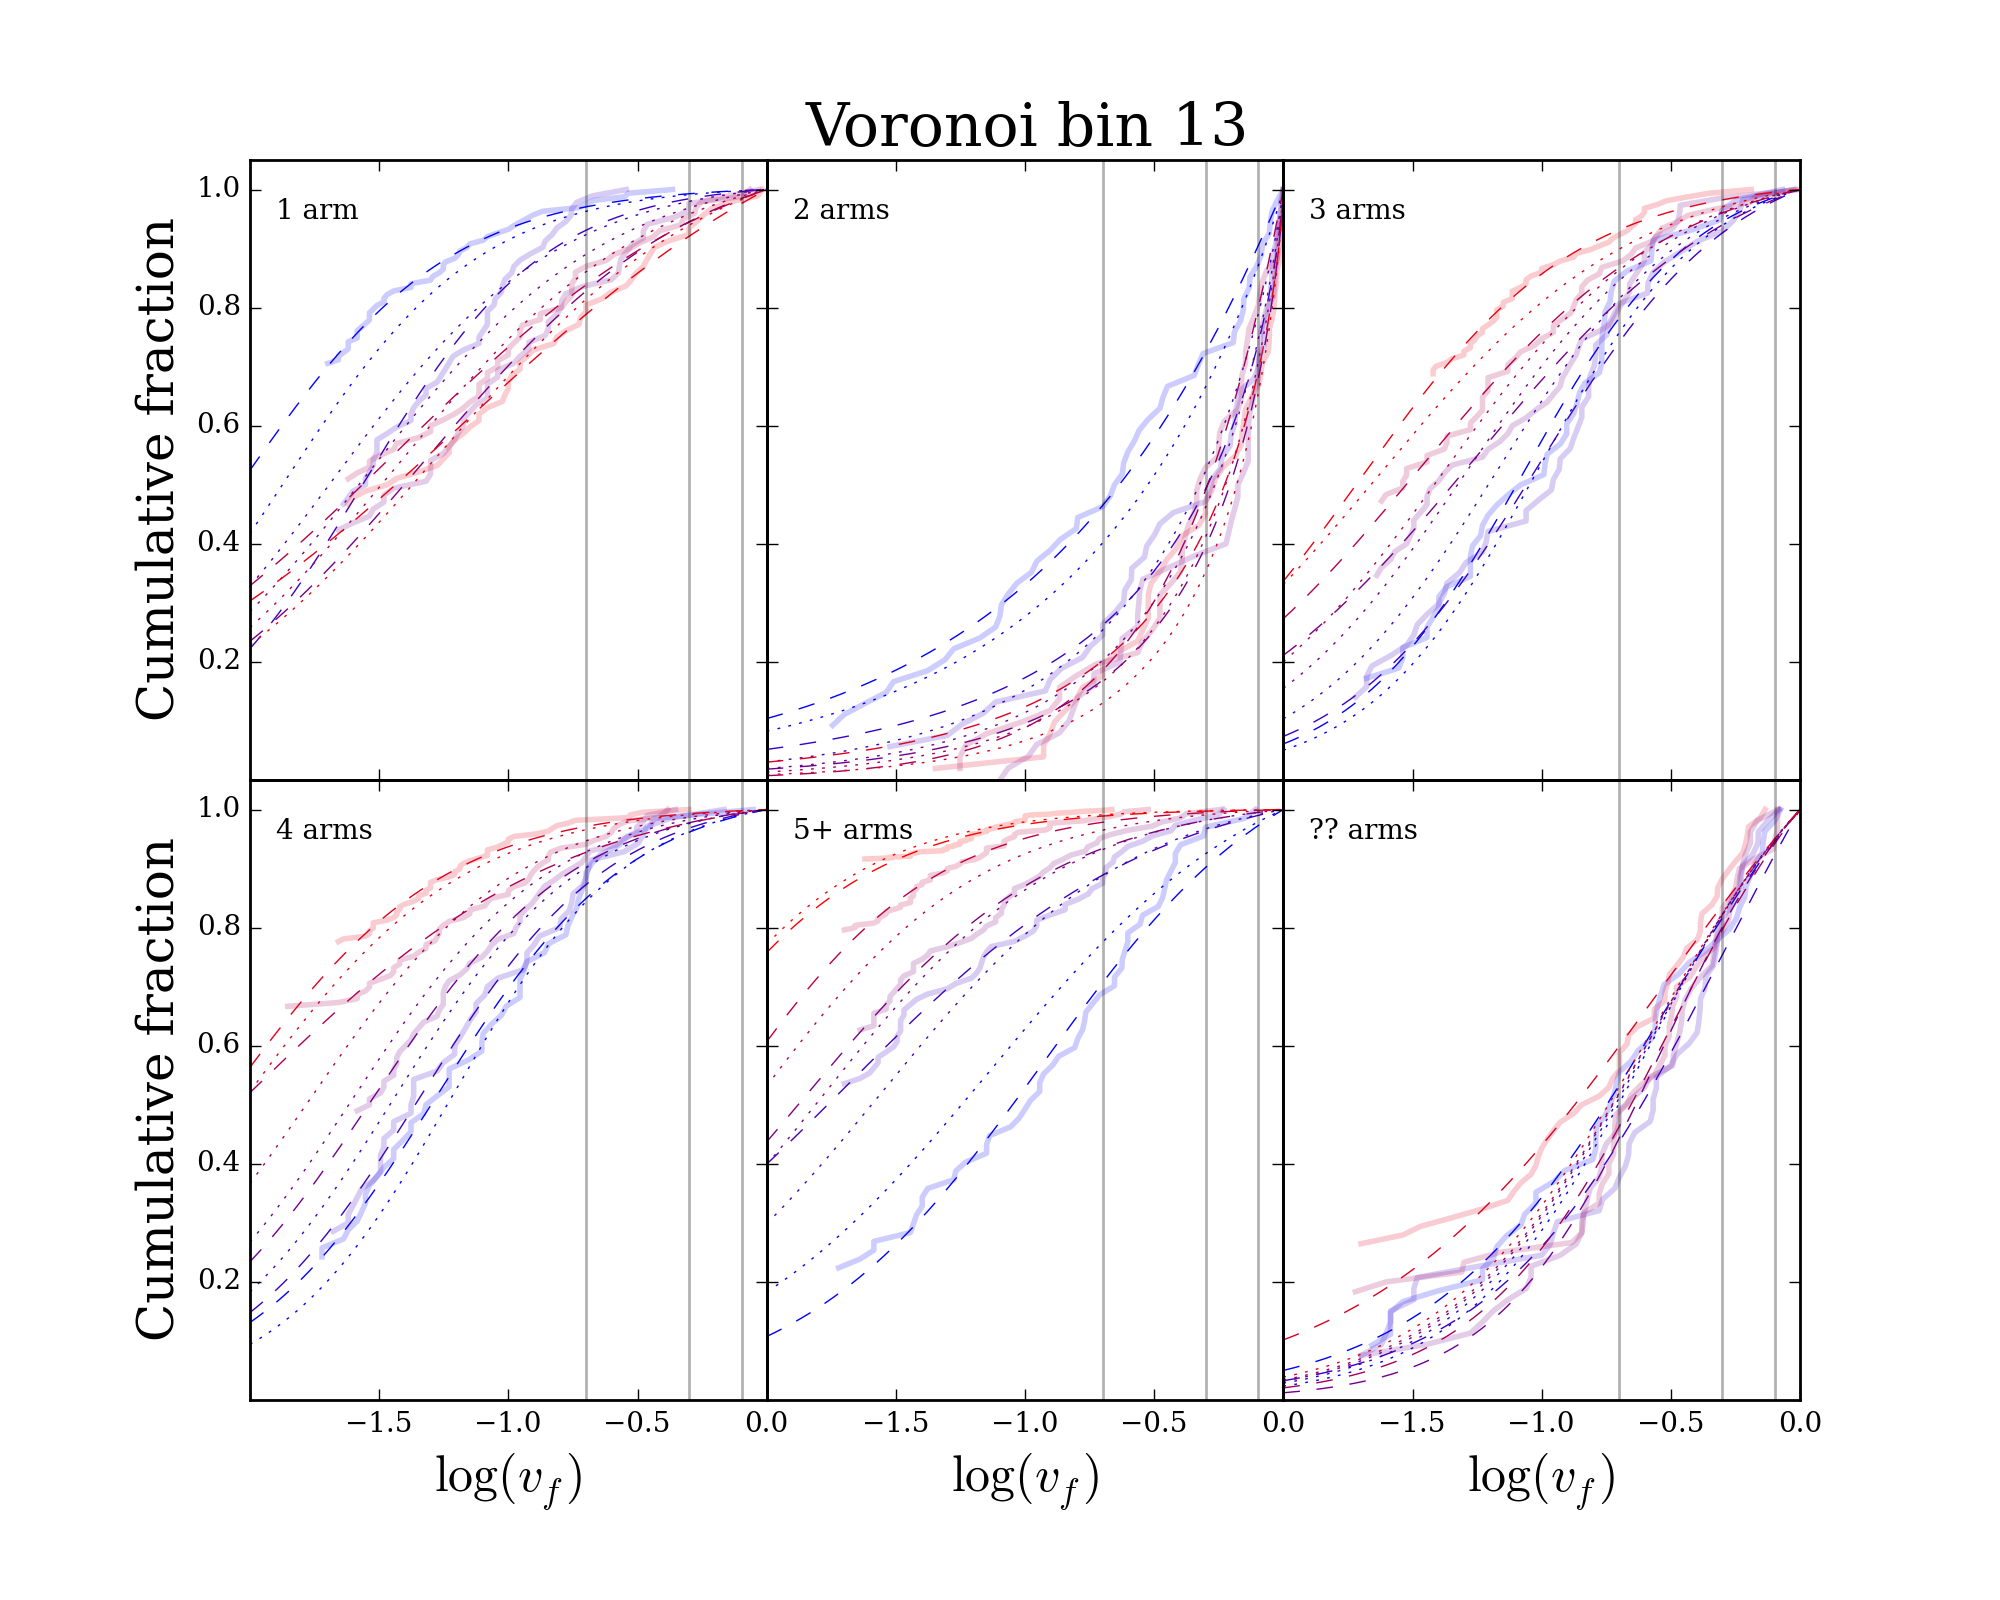

In [43]:
Image('plots/fit_t11_arms_number_vbin13_kcfit2.png')

In [64]:
def debias(data, z_base, kcfunc, kparams, cparams,
           question='t11_arms_number',
           answers=('a31_1', 'a32_2', 'a33_3', 'a34_4',
                    'a36_more_than_4', 'a37_cant_tell')):
    # Debias the dataset
    
    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]
    
    debiased = data[morph_fv_cols]

    # Each galaxy gets a function fit to its M,R and z parameters, which are scaled
    # to the equivalent M and r functions at low z.

    for m, fv_col in enumerate(morph_fv_cols):
        fv = debiased[fv_col]
        fv_nonzero = fv > 0
        log10fv = np.log10(np.asarray(fv[fv_nonzero]))
        
        func, _, _ = get_fit_setup(fit_setup, m)
        ifunc = inverse_f(func)

        d = data[fv_nonzero]
        x = np.array([d['PETROMAG_MR'],
                      np.log10(d['PETROR50_R_KPC']),
                      d['REDSHIFT_1']], np.float64)
        k = kcfunc(x, *kparams[m])
        c = kcfunc(x, *cparams[m])

        # create version of x with all redshifts at z_base
        xb = x.copy()
        xb[-1] = z_base
        
        kb = kcfunc(xb, *kparams[m])
        cb = kcfunc(xb, *cparams[m])

        # possibly deal with any functions outside the k and c limits here
        
        cumfrac = func(log10fv, k, c)
        log10fv_debiased = ifunc(cumfrac, kb, cb)
        fv_debiased = 10**(log10fv_debiased)

        debiased[fv_col][fv_nonzero] = fv_debiased

    return debiased

In [68]:
# Do the debiasing of the entire volume limited sample... (added by Ross)

z_base = 0.03

vl_data = fits.getdata(source_dir+"volume_limited_sample.fits") 
vl_data = Table(vl_data)

debiased = debias(vl_data, z_base, kcfunc, kparams, cparams,
                  question=arm_question, answers=arm_answers)
# Save to fits:
debiased.write(source_dir + 'debiased_volume_limited_sample.fits',
               overwrite=True)

In [60]:
z_base = 0.03

debiased = debias(data, z_base, kcfunc, kparams, cparams,
                  question=arm_question, answers=arm_answers)

debiased.write(source_dir + 'debiased_{}.fits'.format(arm_question),
               overwrite=True)

In [46]:
z_base = 0.03

debiased2 = debias(data, z_base, kcfunc2, kparams2, cparams2,
                  question=arm_question, answers=arm_answers)

debiased2.write(source_dir + 'debiased2_{}.fits'.format(arm_question),
               overwrite=True)

In [56]:
def plot_debiased(data, debiased,
                  question='t11_arms_number',
                  answers=('a31_1', 'a32_2', 'a33_3', 'a34_4',
                           'a36_more_than_4', 'a37_cant_tell'),
                  answerlabels=('1 arm', '2 arms', '3 arms',
                                '4 arms', '5+ arms', '?? arms'),
                  subsample=10):
    # Plot debiased values vs. raw values for comparison. Blue -> red with z.
    
    data = data[::subsample]
    debiased = debiased[::subsample]
    
    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]

    fig, axarr = plt.subplots(2, 3, sharex='col', sharey='row')

    z = data['REDSHIFT_1']

    for m, fv_col in enumerate(morph_fv_cols):
        ax = axarr.ravel()[m]
        sc = ax.scatter(data[fv_col], debiased[fv_col],
                        marker=".", c=z, edgecolor='',
                        cmap=plt.cm.coolwarm,
                        norm=mpl.colors.LogNorm())

        ax.axis((0, 1, 0, 1))
        ax.plot([0,1],[0,1],"k-")

        ax.text(0.4, 0.9, answerlabels[m], fontsize='small', ha='left')

        if m > 2:
            ax.set_xlabel(r"$f_v$")
        if m == 0 or m == 3:
            ax.set_ylabel(r"$f_{v,\mathrm{debiased}}$")

    fig.subplots_adjust(hspace=0, wspace=0, right=0.85)

    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
    cbar = fig.colorbar(sc, cax=cbar_ax, format='%.2f')
    cbar.ax.set_ylabel('redshift')

    fig.savefig('plots/debiased.pdf')

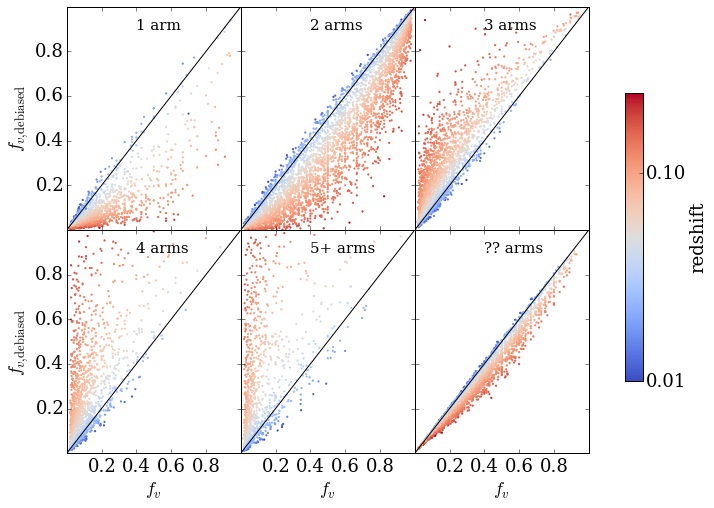

In [48]:
plot_debiased(data, debiased,
              question=arm_question,
              answers=arm_answers,
              answerlabels=arm_answerlabels)

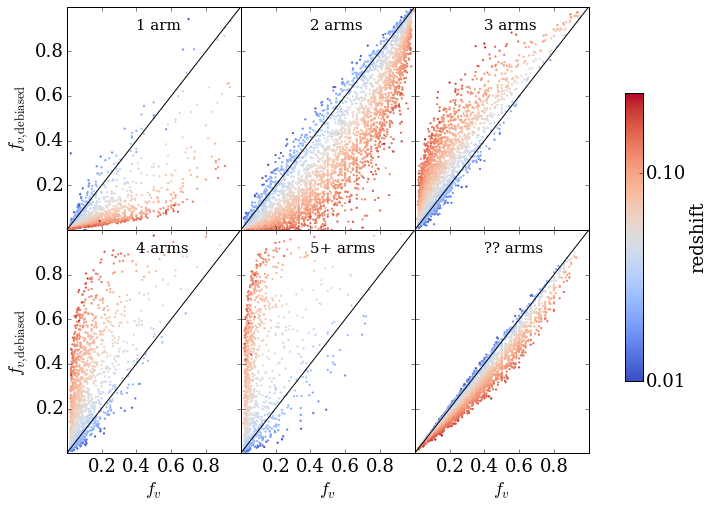

In [49]:
plot_debiased(data, debiased2,
              question=arm_question,
              answers=arm_answers,
              answerlabels=arm_answerlabels)

In [50]:
def plot_vf_histogram(debiased, debiased2=None):
    # Plot histogram of sums of f_v.

    fig, ax = plt.subplots()

    fv = np.array([debiased[c] for c in debiased.colnames], np.float)
    sums = np.sum(fv, axis=0)
    ax.hist(sums, bins=50, histtype='stepfilled', range=(0, 3))
    
    if debiased2 is not None:
        fv = np.array([debiased2[c] for c in debiased2.colnames], np.float)
        sums = np.sum(fv, axis=0)
        ax.hist(sums, bins=50, histtype='step', range=(0, 3), lw=2)

    ax.set_xlabel(r"$\Sigma f_v$")
    ax.set_ylabel(r"$N_{gal}$")

    fig.savefig('plots/vf_histogram.pdf')

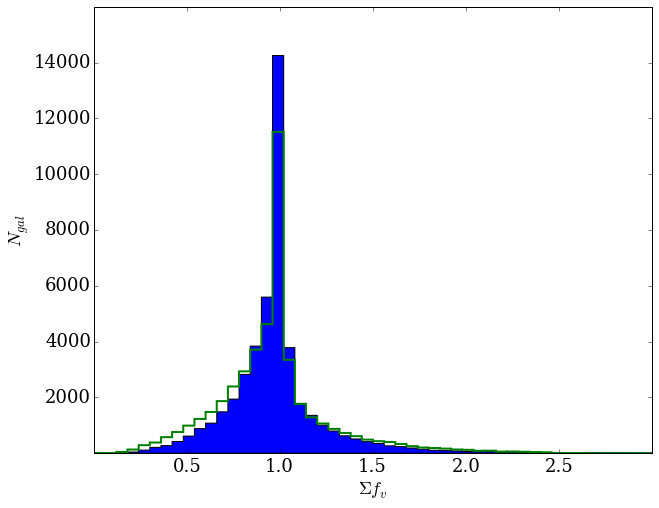

In [51]:
plot_vf_histogram(debiased, debiased2)

In [52]:
redshift_ok = ~np.isnan(data['REDSHIFT_1'])
d = data[redshift_ok]
volume_ok = (d['REDSHIFT_1'] < 0.085) & (d['REDSHIFT_1'] > 0.03) & (d['PETROMAG_MR'] < -21.17)
volume_limit = redshift_ok
volume_limit[redshift_ok] &= volume_ok

In [53]:
data_vl = data[volume_limit]
debiased_vl = debiased[volume_limit]

In [54]:
data_vl.write(source_dir + 'data_vl.fits', overwrite=True)
debiased_vl.write(source_dir + 'debiased_vl_{}.fits'.format(arm_question),
                  overwrite=True)